In [1]:
import pandas as pd
import numpy as np
import glob, os, cv2
from matplotlib import pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from keras import backend as K
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Input,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D,AveragePooling2D,ReLU
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from keras.callbacks import EarlyStopping,CSVLogger,ReduceLROnPlateau

In [4]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

In [5]:
RANDOM_STATE = 54
DIRECTORY = "UTKFace/"
NUM_OF_EPOCHES = 30
CLASSES = [0,1,2,3,4,5,6]

In [6]:
# first number before _ in filenames of images are person's age (in 39_1_20170116174525125.jpg.chip.jpg 39 is the age)
# parsing and returning age for each image in directory
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age)
    except Exception as e:
        print(filepath)
        return None

In [7]:
files = glob.glob(os.path.join(DIRECTORY, "*.jpg"))
data = list(map(parse_filepath, files))

UTKFace\39_1_20170116174525125.jpg.chip.jpg
UTKFace\61_1_20170109142408075.jpg.chip.jpg
UTKFace\61_1_20170109150557335.jpg.chip.jpg


In [8]:
# making data frame with images and ages
df = pd.DataFrame(data)
df['file'] = files
df.columns = ['age', 'file']
df = df.sort_values(by=['age'])
df = df.dropna()
df.head()

,age,file
2226,1.0,UTKFace\1_1_0_20161219205534526.jpg.chip.jpg
2047,1.0,UTKFace\1_0_3_20161219225723376.jpg.chip.jpg
2048,1.0,UTKFace\1_0_3_20161219225759904.jpg.chip.jpg
2049,1.0,UTKFace\1_0_3_20161219225808112.jpg.chip.jpg
2050,1.0,UTKFace\1_0_3_20161219225811120.jpg.chip.jpg


In [9]:
df.shape

(23705, 2)

In [10]:
# grouping age in 7 intervals
def class_label(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [11]:
df['target'] = df['age'].map(class_label)

In [12]:
k = np.bincount(df['target'])
k

array([1605, 1457, 1815, 5572, 7645, 3912, 1699], dtype=int64)

In [13]:
# data is not balanced, so we are undersampling by taking 1600 random instances of the most numerous classes
class_3 = df[4878:10449].sample(frac=1)[:1600]
class_4 = df[10451:18094].sample(frac=1)[:1600]
class_5 = df[18095:22006].sample(frac=1)[:1600]

In [14]:
# deleting all instances of the most numerous classes
df = df.drop(df[df['target']==3].index)
df = df.drop(df[df['target']==4].index)
df = df.drop(df[df['target']==5].index)

In [15]:
# adding 1600 of each
df = pd.concat([df,class_3])
df = pd.concat([df,class_4])
df = pd.concat([df,class_5])

In [16]:
k = np.bincount(df['target'])
k

array([1605, 1457, 1815, 1600, 1600, 1600, 1699], dtype=int64)

In [17]:
df.shape

(11376, 3)

In [18]:
X_files = df['file']
y = df['target']
X = []

In [19]:
df.head()

,age,file,target
2226,1.0,UTKFace\1_1_0_20161219205534526.jpg.chip.jpg,0
2047,1.0,UTKFace\1_0_3_20161219225723376.jpg.chip.jpg,0
2048,1.0,UTKFace\1_0_3_20161219225759904.jpg.chip.jpg,0
2049,1.0,UTKFace\1_0_3_20161219225808112.jpg.chip.jpg,0
2050,1.0,UTKFace\1_0_3_20161219225811120.jpg.chip.jpg,0


In [20]:
for img in X_files:
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    X.append(np.array(image))

In [21]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(y)
Y = to_categorical(Y,7)

In [22]:
X = np.array(X)
X = preprocess_input(X)

In [23]:
X.shape,Y.shape

((11376, 200, 200, 3), (11376, 7))

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.33, stratify=Y, random_state=RANDOM_STATE)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7621, 200, 200, 3), (3755, 200, 200, 3), (7621, 7), (3755, 7))

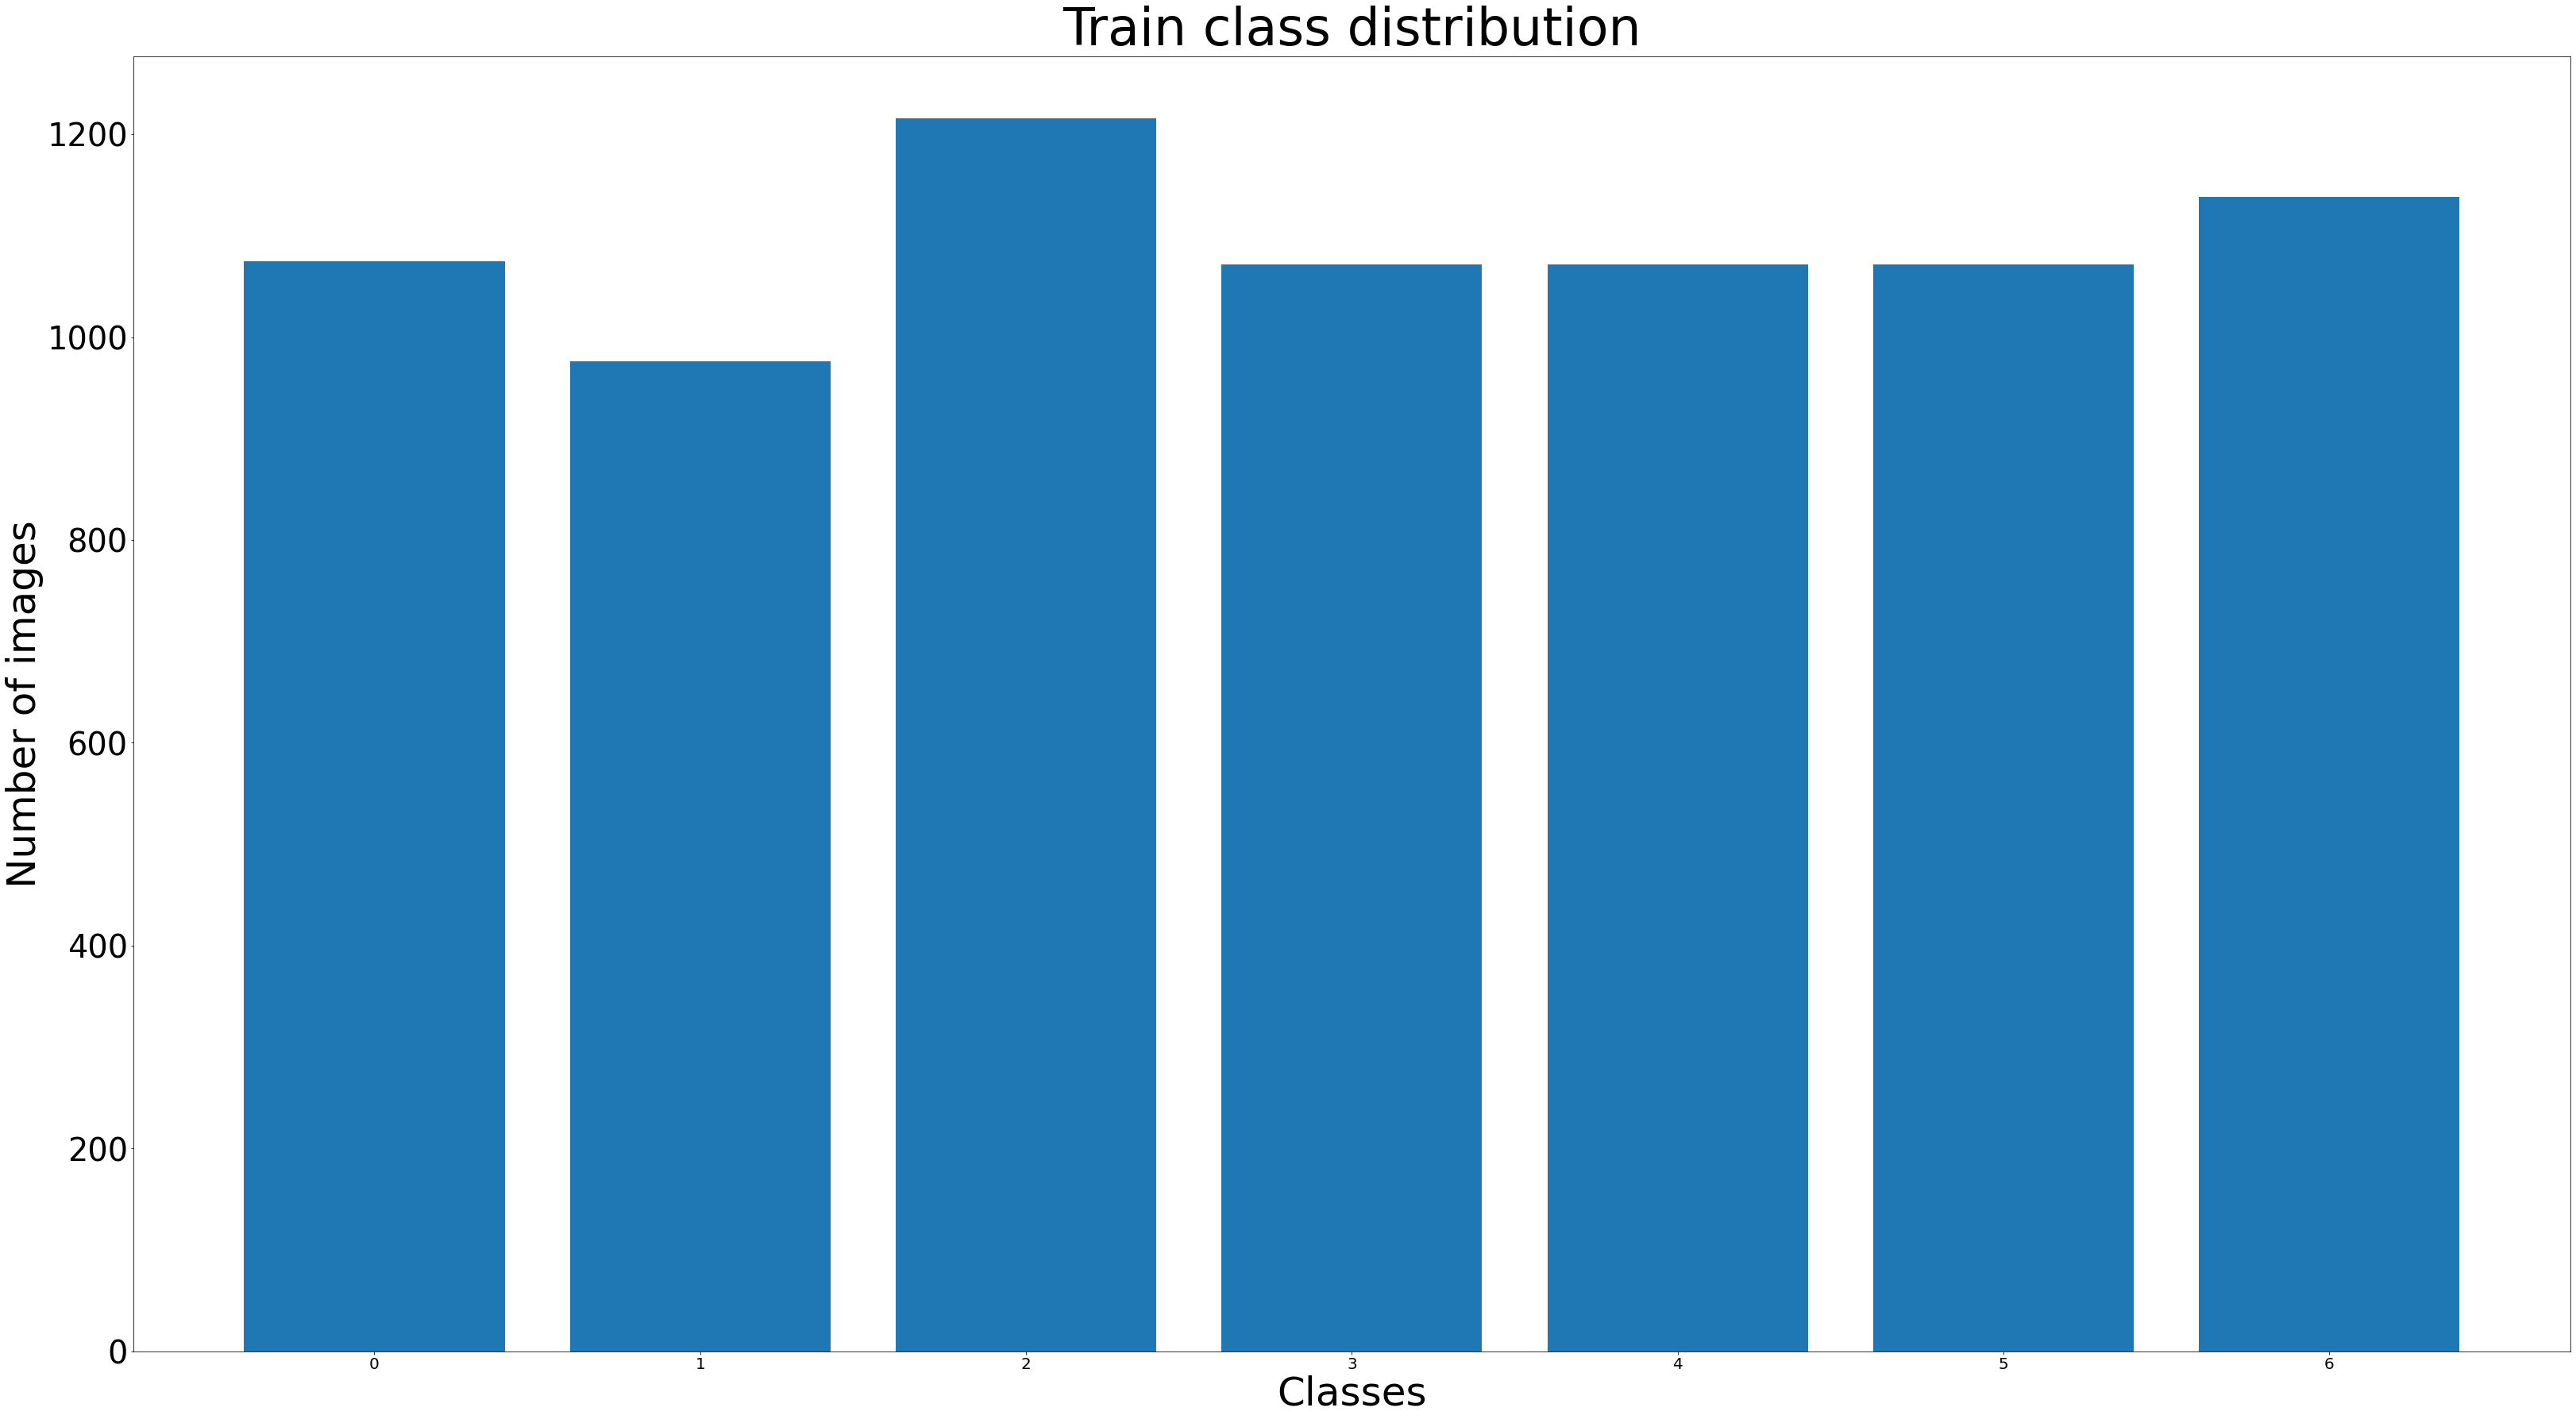

In [26]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(CLASSES,np.bincount(y_train_cls))
plt.show()

In [27]:
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0005,
    verbose=1
)

stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=False,
)

callbacks = [reduce, stop]

In [28]:
model = Sequential([

Conv2D(filters=16, kernel_size=(5,5), strides=(5,5), activation='relu', input_shape=(200, 200, 3)),
Conv2D(filters=32, kernel_size=(3,3), strides=(5,5), activation='relu'),
Conv2D(filters=64, kernel_size=(3,3), strides=(5,5), activation='relu', padding='same'),
MaxPool2D(pool_size=(3,3), padding='same'),
Conv2D(filters=128, kernel_size=(3,3), strides=(5,5), activation='relu', padding='same'),
MaxPool2D(pool_size=(3,3), padding='same'),
Conv2D(filters=128, kernel_size=(3,3), strides=(5,5), activation='relu', padding='same'),
MaxPool2D(pool_size=(3,3), padding='same'),
GlobalAveragePooling2D(),
Dense(1024, activation='relu'),
Dropout(0.3),
Dense(7, activation='softmax')
          ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 16)        1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                    

In [29]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs = NUM_OF_EPOCHES,
                    verbose = 1,
                    validation_split=0.2
                    )

Epoch 1/30
191/191 [==============================] - 18s 82ms/step - loss: 1.7866 - accuracy: 0.2459 - val_loss: 1.7046 - val_accuracy: 0.2603
Epoch 2/30
191/191 [==============================] - 5s 28ms/step - loss: 1.5863 - accuracy: 0.3410 - val_loss: 1.5590 - val_accuracy: 0.3430
Epoch 3/30
191/191 [==============================] - 5s 27ms/step - loss: 1.4317 - accuracy: 0.3952 - val_loss: 1.3744 - val_accuracy: 0.4000
Epoch 4/30
191/191 [==============================] - 5s 26ms/step - loss: 1.3309 - accuracy: 0.4421 - val_loss: 1.3469 - val_accuracy: 0.4184
Epoch 5/30
191/191 [==============================] - 5s 26ms/step - loss: 1.2450 - accuracy: 0.4864 - val_loss: 1.3461 - val_accuracy: 0.4308
Epoch 6/30
191/191 [==============================] - 5s 27ms/step - loss: 1.1712 - accuracy: 0.5184 - val_loss: 1.2992 - val_accuracy: 0.4636
Epoch 7/30
191/191 [==============================] - 5s 28ms/step - loss: 1.1191 - accuracy: 0.5387 - val_loss: 1.2949 - val_accuracy: 0.480

In [33]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [34]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    print(conf_mat)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

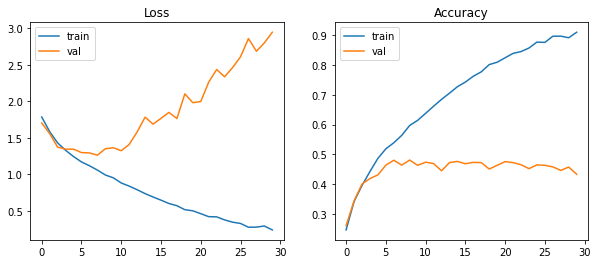

In [35]:
plot_acc_loss(history, NUM_OF_EPOCHES)

In [36]:
evaluate_model(model, X_train, y_train, CLASSES, "model_train_evaluation")

239/239 [==============================] - 2s 9ms/step - loss: 0.7935 - accuracy: 0.8137
Test loss: 0.7934969067573547
Test accuracy: 0.8136727213859558
239/239 [==============================] - 2s 9ms/step
[[1006   45    5    5    2    7    5]
 [  39  823   76   12    6   13    7]
 [   4   59  944   79   95   28    7]
 [   1    7   42  795  200   21    6]
 [   3    5   25   51  827  153    8]
 [   0    9   10   10   57  944   42]
 [   4    9   12    5   17  229  862]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1075
           1       0.86      0.84      0.85       976
           2       0.85      0.78      0.81      1216
           3       0.83      0.74      0.78      1072
           4       0.69      0.77      0.73      1072
           5       0.68      0.88      0.77      1072
           6       0.92      0.76      0.83      1138

    accuracy                           0.81      7621
   macro avg       0.82      0.82    

In [37]:
evaluate_model(model, X_test, y_test, CLASSES, "model_test_evaluation")

118/118 [==============================] - 4s 30ms/step - loss: 3.0410 - accuracy: 0.4386
Test loss: 3.0410263538360596
Test accuracy: 0.43861517310142517
118/118 [==============================] - 1s 10ms/step
[[372 118  10   5   6   4  15]
 [ 67 222 115  15  19  24  19]
 [  8  63 207 113 125  66  17]
 [  6  21  79 146 187  67  22]
 [  2  20  70  84 201 124  27]
 [  2  16  36  27 104 277  66]
 [ 12  24  19  11  48 225 222]]
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       530
           1       0.46      0.46      0.46       481
           2       0.39      0.35      0.36       599
           3       0.36      0.28      0.31       528
           4       0.29      0.38      0.33       528
           5       0.35      0.52      0.42       528
           6       0.57      0.40      0.47       561

    accuracy                           0.44      3755
   macro avg       0.46      0.44      0.44      3755
weighted avg       0.46      

In [38]:
model.save('models/model_with_Adam')

INFO:tensorflow:Assets written to: models/model_with_Adam\assets


INFO:tensorflow:Assets written to: models/model_with_Adam\assets
